<a href="https://colab.research.google.com/github/egomez11/Login_autenticado/blob/main/Optimizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Afinación del modelo

entrenar modelos de 1, 5 , 15 min para corroborar las predicciones variando las cantidades de steps

In [14]:
!pip install pandas_ta
!pip install keras-tuner -q

In [15]:
from google.colab import drive # libreria de drive
import pandas as pd
import pandas_ta as ta
import datetime
import numpy as np
import keras_tuner
import keras
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [16]:
import tensorflow as tf
tf.test.is_gpu_available()

False

In [17]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [14]:
tf.device('/device:GPU:0')

In [4]:
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [16]:
ruta = '/gdrive/MyDrive/Trading_models/datos/'
df = pd.read_csv(ruta + 'EURUSD.csv', index_col=0)
df.head(2)

,time,open,high,low,close,tick_volume,spread,real_volume
0,2021-08-12 03:45:00,1.17403,1.17419,1.17375,1.17401,318,0,0
1,2021-08-12 04:00:00,1.17401,1.17413,1.17377,1.17385,316,0,0


In [17]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

In [18]:
df = df.drop(columns=['real_volume','spread'], axis=1)

In [19]:
df.describe()

,open,high,low,close,tick_volume
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.081853,1.082208,1.081494,1.081853,944.551286
std,0.045647,0.045577,0.045714,0.045645,906.315811
min,0.953920,0.955170,0.953570,0.953910,1.000000
25%,1.059960,1.060380,1.059550,1.059960,346.000000
50%,1.082670,1.082960,1.082360,1.082670,680.000000
75%,1.101230,1.101610,1.100882,1.101240,1255.000000
max,1.190170,1.190910,1.189450,1.190210,21483.000000


In [20]:
df = df.set_index('time')

In [21]:
df.head(4)

,open,high,low,close,tick_volume
time,,,,,
2021-08-12 03:45:00,1.17403,1.17419,1.17375,1.17401,318
2021-08-12 04:00:00,1.17401,1.17413,1.17377,1.17385,316
2021-08-12 04:15:00,1.17385,1.17401,1.17376,1.17389,406
2021-08-12 04:30:00,1.17385,1.17412,1.17385,1.17391,269


<Axes: xlabel='time'>

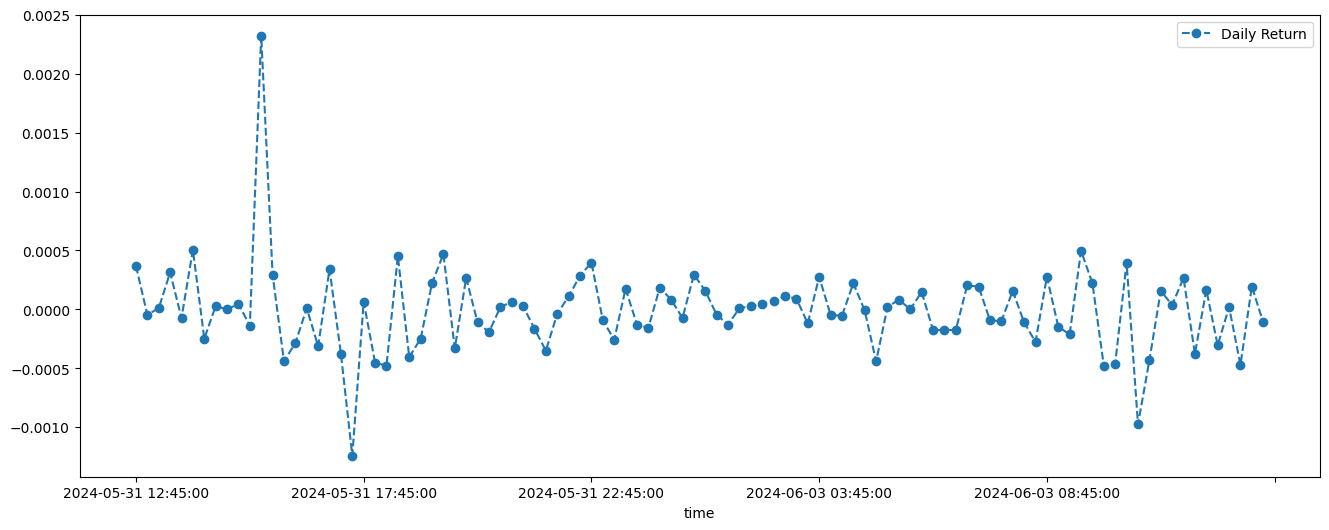

In [22]:
df_t1 = df.copy()
df_t1['Daily Return'] = df_t1['close'].pct_change()
plt.figure(figsize=(16,6))
df_t1.tail(100)['Daily Return'].plot(legend=True, linestyle='--', marker='o')

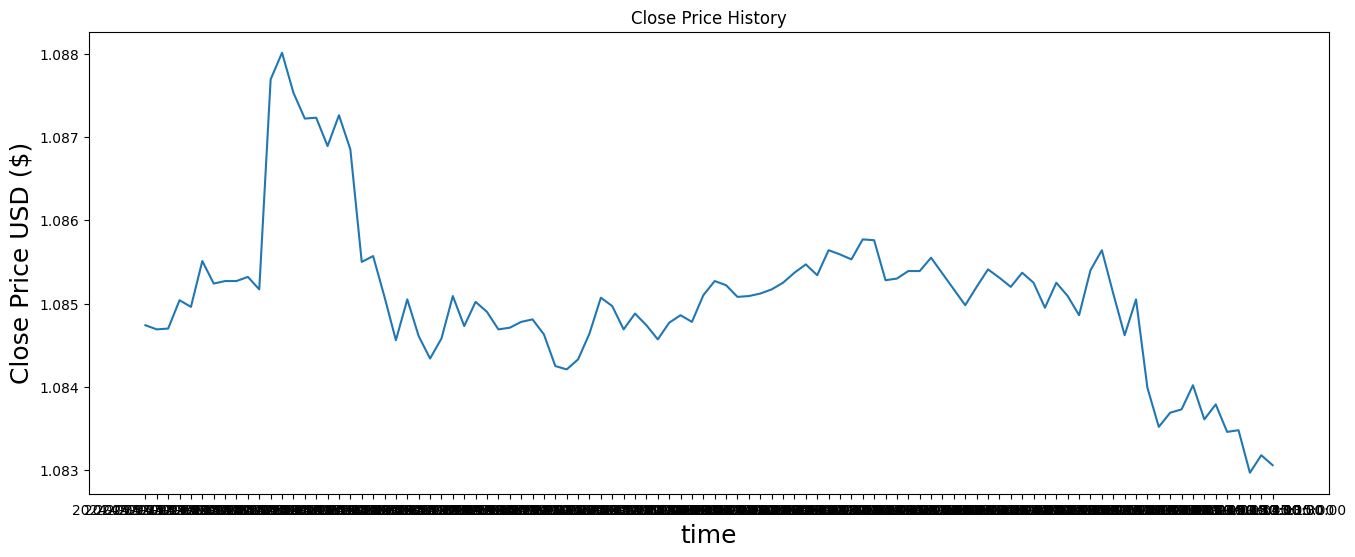

In [23]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df.tail(100)['close'])
plt.xlabel('time', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [24]:
def add_indicators(df, column_name, slow, fast, n_rsi):
    # Calculate the EMA_slow and EMA_fast indicators
    df.ta.sma(fast, append=True)
    df.ta.ema(slow, append=True)
    df.ta.macd(fast, slow, signal=n_rsi, append=True)
    df.ta.rsi(n_rsi, append=True)
    df.ta.atr(append=True)
    df['signal'] = 0

    for i in range(1, len(df)):
        if df[f'EMA_{slow}'][i] - df[f'SMA_{fast}'][i] < 0 and df[f'EMA_{slow}'][i-1] - df[f'SMA_{fast}'][i-1] > 0:
            df['signal'][i] = -1
        elif df[f'EMA_{slow}'][i] - df[f'SMA_{fast}'][i] > 0 and df[f'EMA_{slow}'][i-1] - df[f'SMA_{fast}'][i-1] < 0:
            df['signal'][i] = 1

    df = df[slow + n_rsi:].copy()

    return df

In [25]:
df_t1 = add_indicators(df_t1, 'close', 81, 13,14)

Streaming output truncated to the last 5000 lines.
<ipython-input-24-0f9a3aa03742>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][i] = -1
<ipython-input-24-0f9a3aa03742>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][i] = 1
<ipython-input-24-0f9a3aa03742>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][i] = -1
<ipython-input-24-0f9a3aa03742>:14: SettingWithCopyWarning: 
A value is trying t

In [26]:
df_t1.describe()

,open,high,low,close,tick_volume,Daily Return,SMA_13,EMA_81,MACD_13_81_14,MACDh_13_81_14,MACDs_13_81_14,RSI_14,ATRr_14,signal
count,69905.000000,69905.000000,69905.000000,69905.000000,69905.000000,69905.000000,69905.000000,69905.000000,69905.000000,6.990500e+04,69905.000000,69905.000000,69905.000000,69905.000000
mean,1.081728,1.082083,1.081369,1.081728,945.310049,-0.000001,1.081736,1.081779,-0.000043,-1.162105e-08,-0.000043,49.921845,0.000716,0.000000
std,0.045552,0.045482,0.045619,0.045550,906.648991,0.000534,0.045551,0.045538,0.001899,5.005707e-04,0.001821,11.883897,0.000333,0.136371
min,0.953920,0.955170,0.953570,0.953910,1.000000,-0.011400,0.955403,0.957552,-0.010768,-3.891499e-03,-0.009901,7.743939,0.000168,-1.000000
25%,1.059930,1.060330,1.059520,1.059920,346.000000,-0.000215,1.059941,1.060097,-0.001066,-2.512101e-04,-0.001025,41.846210,0.000472,0.000000
50%,1.082620,1.082920,1.082320,1.082620,681.000000,0.000000,1.082622,1.082738,-0.000029,4.565384e-06,-0.000034,49.939247,0.000642,0.000000
75%,1.101080,1.101460,1.100700,1.101070,1256.000000,0.000215,1.101082,1.100997,0.000929,2.548035e-04,0.000899,57.921659,0.000882,0.000000
max,1.190170,1.190910,1.189450,1.190210,21483.000000,0.016147,1.189118,1.188004,0.009436,5.511210e-03,0.008832,92.767878,0.002762,1.000000


In [27]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(df_t1, df_t1['close'], test_size=0.1, random_state= 42 , shuffle=False)

In [28]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_t1)

scaler_y = MinMaxScaler()
scaled_data_y = scaler_y.fit_transform(df_t1[["close"]])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, scaled_data_y, test_size=0.1, random_state=42,shuffle=False)

In [31]:
X_train, X_test, y_train, y_test = np.array(X_train),np.array(X_test), np.array(y_train), np.array(y_test)

In [32]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape

(62914, 14, 1)

In [33]:
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
y_train.shape

(62914, 1)

#Building and Training Model

In [34]:
def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), return_sequences=True, input_shape= ( X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(30, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))

    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])

    return model

tuner = kt.RandomSearch(model_builder, objective="mse", max_trials = 4, executions_per_trial =2,directory = "./")

tuner.search(x=X_train, y=y_train, epochs = 10, batch_size =256, validation_data=(X_test, y_test))

Reloading Tuner from ./untitled_project/tuner0.json


In [5]:
best_model = tuner.get_best_models(num_models=1)[0]

NameError: name 'tuner' is not defined

In [36]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="mse", direction="min")

Trial 1 summary
Hyperparameters:
input_unit: 96
n_layers: 4
lstm_0_units: 384
layer_2_neurons: 288
Dropout_rate: 0.4
dense_activation: sigmoid
lstm_1_units: 64
lstm_2_units: 32
lstm_3_units: 32
Score: 6.940339881111868e-05

Trial 3 summary
Hyperparameters:
input_unit: 256
n_layers: 4
lstm_0_units: 480
layer_2_neurons: 384
Dropout_rate: 0.30000000000000004
dense_activation: sigmoid
lstm_1_units: 320
lstm_2_units: 416
lstm_3_units: 512
Score: 7.048363477224484e-05

Trial 2 summary
Hyperparameters:
input_unit: 416
n_layers: 4
lstm_0_units: 96
layer_2_neurons: 416
Dropout_rate: 0.4
dense_activation: relu
lstm_1_units: 32
lstm_2_units: 32
lstm_3_units: 384
Score: 0.00015323714615078643

Trial 0 summary
Hyperparameters:
input_unit: 480
n_layers: 2
lstm_0_units: 32
layer_2_neurons: 384
Dropout_rate: 0.4
dense_activation: relu
lstm_1_units: 32
Score: 0.00015740710659883916


In [37]:
y_pred = best_model.predict(X_test)

219/219 [==============================] - 4s 7ms/step


In [38]:
y_pred.shape

(6991, 1)

In [39]:
y_pred = scaler_y.inverse_transform(y_pred)

In [40]:
valid = pd.DataFrame(y_test0)
valid['Predicted'] = y_pred

##Validating model results on test data and plotting results

In [41]:
valid.head()

,close,Predicted
time,,
2024-02-21 14:45:00,1.08029,1.084879
2024-02-21 15:00:00,1.08096,1.085802
2024-02-21 15:15:00,1.08047,1.086078
2024-02-21 15:30:00,1.08093,1.085781
2024-02-21 15:45:00,1.08101,1.086068


In [2]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('time', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(y_train0)
plt.plot(valid[['Close', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(y_train0)
plt.plot(valid[['Close', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### Otro modelo

In [373]:
step = 5
date_time_key = "time"
past = 120
future = 15
train_size = 0.8

output_length = 1
sequence_length = past


learning_rate = 0.001
batch_size = 256
epochs = 10

In [374]:
def add_indicators(df, column_name, slow, fast, n_rsi):
    # Calculate the EMA_slow and EMA_fast indicators
    df.ta.sma(fast, append=True)
    df.ta.ema(slow, append=True)
    df.ta.macd(fast, slow, signal=n_rsi, append=True)
    df.ta.rsi(n_rsi, append=True)
    df.ta.atr(append=True)
    df['signal'] = 0

    for i in range(1, len(df)):
        if df[f'EMA_{slow}'][i] - df[f'SMA_{fast}'][i] < 0 and df[f'EMA_{slow}'][i-1] - df[f'SMA_{fast}'][i-1] > 0:
            df['signal'][i] = -1
        elif df[f'EMA_{slow}'][i] - df[f'SMA_{fast}'][i] > 0 and df[f'EMA_{slow}'][i-1] - df[f'SMA_{fast}'][i-1] < 0:
            df['signal'][i] = 1

    df = df[slow + n_rsi:].copy()

    return df

In [375]:
df = add_indicators(dataset, 'close', 81, 13,14)

Streaming output truncated to the last 5000 lines.
<ipython-input-374-0f9a3aa03742>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][i] = -1
<ipython-input-374-0f9a3aa03742>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][i] = 1
<ipython-input-374-0f9a3aa03742>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][i] = -1
<ipython-input-374-0f9a3aa03742>:14: SettingWithCopyWarning: 
A value is tryi

In [376]:
df[df['signal'] != 0]

,time,open,high,low,close,tick_volume,spread,real_volume,SMA_13,EMA_81,MACD_13_81_14,MACDh_13_81_14,MACDs_13_81_14,RSI_14,ATRr_14,signal
101,2021-08-13 05:00:00,1.17394,1.17400,1.17391,1.17398,113,0,0,1.173682,1.173676,0.000027,0.000179,-0.000153,60.201403,0.000263,-1
122,2021-08-13 10:15:00,1.17350,1.17351,1.17302,1.17341,605,0,0,1.173712,1.173721,-0.000066,-0.000110,0.000044,41.548779,0.000298,1
130,2021-08-13 12:15:00,1.17418,1.17440,1.17405,1.17434,427,0,0,1.173771,1.173759,0.000151,0.000121,0.000030,63.974332,0.000314,-1
230,2021-08-16 13:15:00,1.17819,1.17850,1.17804,1.17828,547,0,0,1.178447,1.178454,-0.000025,-0.000271,0.000246,43.382724,0.000460,1
527,2021-08-19 15:30:00,1.16962,1.17041,1.16945,1.16975,1058,0,0,1.169497,1.169415,0.000021,0.000455,-0.000434,61.031486,0.000639,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69647,2024-05-28 21:30:00,1.08584,1.08589,1.08554,1.08571,430,0,0,1.086987,1.087037,-0.000307,-0.000441,0.000134,29.604755,0.000488,1
69806,2024-05-30 13:15:00,1.08093,1.08152,1.08084,1.08151,396,0,0,1.080993,1.080940,0.000022,0.000561,-0.000539,63.648788,0.000529,-1
69872,2024-05-31 05:45:00,1.08150,1.08169,1.08115,1.08116,337,0,0,1.082547,1.082620,-0.000301,-0.000545,0.000245,14.773138,0.000322,1
69897,2024-05-31 12:00:00,1.08335,1.08450,1.08335,1.08411,648,0,0,1.082567,1.082467,0.000354,0.000493,-0.000139,72.235724,0.000477,-1


In [377]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [378]:
try:
    df = df.drop(columns=['real_volume', 'spread', 'tick_volume'], axis=1)
except:
    pass

train_split = int(train_size * int(df.shape[0]))

def set_datos(df, train_split, past, future):

    features = df.copy()
    try:
        features['time'] = pd.to_datetime(df['time'])
        features.set_index('time', inplace=True)
        features.index = df[date_time_key]
    except:
        pass

    features = normalize(features.values, train_split)
    features = pd.DataFrame(features)

    train_data = features.loc[0 : train_split - 1]
    val_data = features.loc[train_split:]
    return features, train_data, val_data

In [379]:
features, train_data, val_data = set_datos(df, train_split, past, future)
features.shape, train_data.shape, val_data.shape

((69905, 12), (55924, 12), (13981, 12))

In [380]:
def array_datos(features, train_data, val_data, past, future, train_split ):
    selected_features = features.columns.values
    start = past + future
    end = start + len(train_data)

    x_train = train_data[[i for i in range(len(selected_features))]].values
    y_train = features.iloc[start:end][[output_length]]

    x_end = len(val_data) - past - future
    label_start = train_split + past + future

    x_val = val_data.iloc[:x_end][[i for i in range(len(selected_features))]].values
    y_val = features.iloc[label_start:][[1]]
    return x_train, y_train, x_val, y_val

In [381]:
x_train, y_train, x_val, y_val = array_datos(features, train_data, val_data, past, future, train_split)

In [382]:
x_train.shape

(55924, 12)

In [414]:
import pandas as pd
import matplotlib.pyplot as plt
import keras

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length= sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [415]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length= sequence_length,
    sampling_rate= step,
    batch_size=batch_size,
)

In [416]:
dataset_val

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 12), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [403]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 12)
Target shape: (256, 1)


In [418]:
inputs

<KerasTensor: shape=(None, 120, 12) dtype=float32 (created by layer 'input_2')>

In [405]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 12)]         0         
                                                                 
 lstm (LSTM)                 (None, 32)                5760      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5793 (22.63 KB)
Trainable params: 5793 (22.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [293]:
path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
216/217 [============================>.] - ETA: 0s - loss: 0.1670
Epoch 1: val_loss improved from inf to 0.01935, saving model to model_checkpoint.weights.h5
217/217 [==============================] - 33s 141ms/step - loss: 0.1670 - val_loss: 0.0194
Epoch 2/10
216/217 [============================>.] - ETA: 0s - loss: 0.0629
Epoch 2: val_loss improved from 0.01935 to 0.01856, saving model to model_checkpoint.weights.h5
217/217 [==============================] - 32s 146ms/step - loss: 0.0629 - val_loss: 0.0186
Epoch 3/10
217/217 [==============================] - ETA: 0s - loss: 0.0482
Epoch 3: val_loss improved from 0.01856 to 0.01820, saving model to model_checkpoint.weights.h5
217/217 [==============================] - 34s 158ms/step - loss: 0.0482 - val_loss: 0.0182
Epoch 4/10
217/217 [==============================] - ETA: 0s - loss: 0.0419
Epoch 4: val_loss improved from 0.01820 to 0.01779, saving model to model_checkpoint.weights.h5
217/217 [===========================

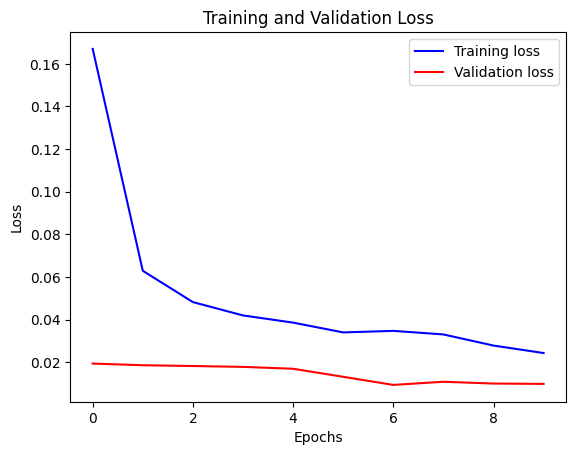

In [294]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

8/8 [==============================] - 1s 12ms/step


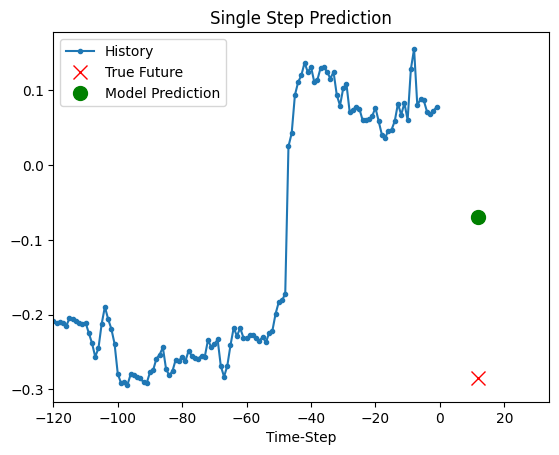

8/8 [==============================] - 0s 13ms/step


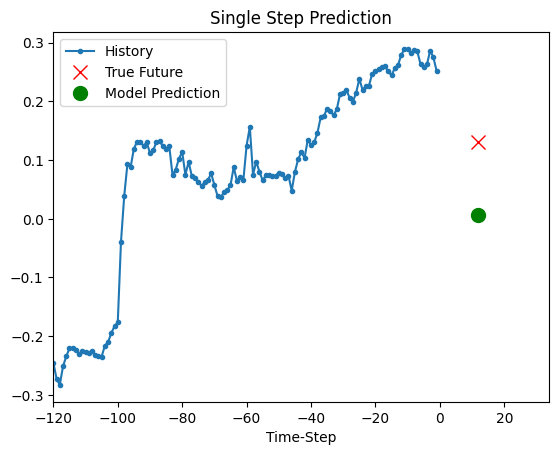

8/8 [==============================] - 0s 12ms/step


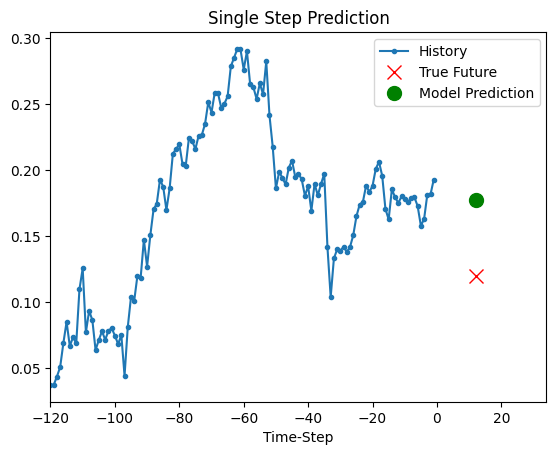

8/8 [==============================] - 0s 13ms/step


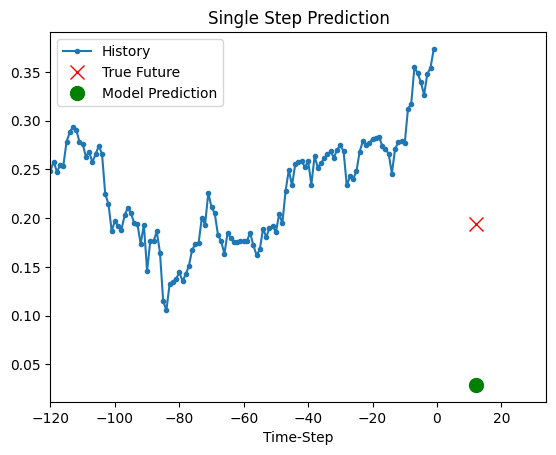

8/8 [==============================] - 0s 18ms/step


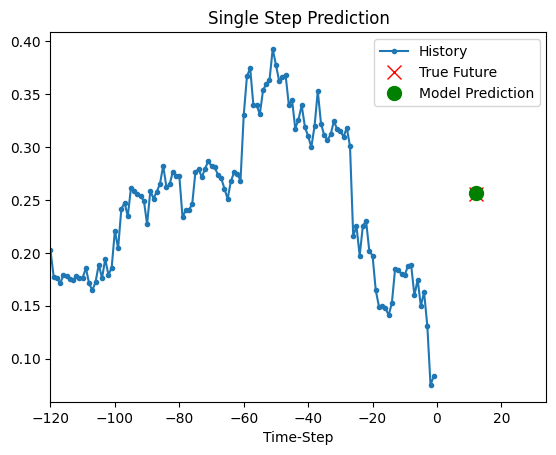

In [295]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [482]:
import tensorflow as tf

# Semilla generador aleatorio
tf.random.set_seed(123)

def crear_modelo(hp):
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length= sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
    )

    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length= sequence_length,
    sampling_rate= step,
    batch_size=batch_size,
    )

    for batch in dataset_train.take(1):
        inputs, targets = batch

    # Contenedor vacío
    inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
    lstm_out = keras.layers.LSTM(32)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # N° de capas ocultas

    model.add(keras.layers.Dense(hp.Choice('units', [32, 96, 32]), activation='relu'))

    # tasa de aprendizaje
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_activation = hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')

    # Capa densa y funcion de activacion
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation= hp_activation))

    # Capa de abandono
    #model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))

    # compilar el modelo
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                  metrics=["accuracy"])

    return model

In [484]:
# Verificar si la función construye el modelo correctamente
import keras_tuner

crear_modelo(keras_tuner.HyperParameters())

AttributeError: 'Functional' object has no attribute 'add'

In [396]:
tuner = keras_tuner.RandomSearch(
    hypermodel=crear_modelo,  # La función que creamos anteriormente
    objective="val_accuracy", # La métrica de desempeño a usar en la afinación
    max_trials=10, # Número total de combinaciones a probar
    directory="afinacion_red", # Directorio local donde se almacenarán los resultados de entrenamiento
    project_name="trials", # Subdirectorio donde se almacenarán los resultados
    overwrite = True, # Para sobre-escribir los directorios cada vez que afinemos
)

In [397]:
# Imprimir en pantalla el espacio de búsqueda
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 60, 'step': 20, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [398]:
# Afinar los hiperparámetros
tuner.search(inputs,
             targets,
             epochs=3,
             validation_data=(x_val, y_val))

Trial 2 Complete [00h 00m 00s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 01s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_layers
20                |20                |units_0
0.001             |0.01              |learning_rate
40                |20                |units_1



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, i

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 266, in <genexpr>
    int(i.shape[0]) for i in tf.nest.flatten(inputs)
TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


In [ ]:
# Imprimir resumen de la afinación
tuner.results_summary()

In [ ]:
# Extraer el mejor modelo
mejor_modelo = tuner.get_best_models(num_models=1)[0]
mejor_modelo.summary()

In [ ]:
# Predicciones sobre el set de prueba
logits = mejor_modelo.predict(x_test)
preds = (logits > 0.5).astype(int)
print(preds)

In [478]:
import tensorflow as tf

# Semilla generador aleatorio
tf.random.set_seed(123)

def build_model(hp):
    # Contenedor vacio
    model = tf.keras.Sequential()

    # Capa de entreda
    mmodel.add(tf.keras.layers.Input(shape=(120,12)))

    # N° de capas ocultas

    model.add(keras.layers.Dense(hp.Choice('units', [32, 96, 32]), activation='relu'))

    # tasa de aprendizaje
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_activation = hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')

    # Capa densa y funcion de activacion
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation= hp_activation))

    # Capa de abandono
    #model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))

    # compilar el modelo
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                  metrics = ['mse'])

    return model

In [485]:
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=2,
        executions_per_trial=1
        )

Reloading Tuner from ./untitled_project/tuner0.json


In [486]:
tuner.search(
        x=x_train,
        y=y_train,
        validation_data=(x_val,y_val),
)

In [487]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  model.add(keras.layers.Dense(1, activation='relu'))
  model.compile(loss='mse')
  return model

In [488]:
best_model = tuner.get_best_models(num_models=1)[0]

NameError: name 'mmodel' is not defined